In [ ]:
Image(url='http://www.teamnetwork.org/files/home/team-header-1000.gif')

# Classifying Wildlife Camera Trap Images for Conservation International’s Tropical Ecology Assessment and Monitoring Network

## Problem Statement

Conservation Internaitonal's TEAM Network has labeled camera trap images of wildlife species

- Images require manual classification from experts in the field
- Highly unbalanced classes of species
- Many of the images are misclassified
- There is a class of unlabeled/unknown images
- Existence of endangered species images preclude the use of citizen scientists to help classify images

## [Data Analysis and Exploration](#Data-Analysis-and-Exploration)

## [Classification Piepline: Image Segmentation](#Image-Segmentation)

- Manual Cropping
- Image Segmentation with Graph Cut 
http://cmp.felk.cvut.cz/~smidm/python-packages-for-graph-cuts-on-images.html (TBD)


## [Classification Pipeline: Feature Extraction](#Feature-Extraction)
- Template Matching
- Histogram Comparison
- Scale Invariant Feature Transform (SIFT)
- Bag of Visual Words

## [Classification Pipeline: Classification](#Classification)
- Linear SVM
- k-means
- Ada boost

## Set Up

In [1]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark -u -n -v -p pandas,numpy,cv2,sklearn,matplotlib -m

import pandas as pd
import numpy as np
import sys
import os
# import PIL
# import sift_pyocl # uses pyOpenCL to access GPUs and other massively parallel compute devices from Python
# import cyvlfeat as vl # a Python (cython) wrapper of the popular VLFeat library
import cv2

import glob
import random
import warnings

from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.externals import joblib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Math

ROWS = 180  #720
COLS = 320 #1280
CHANNELS = 3
SPECIES_CLASSES = ['Loxodonta']

last updated: Sun Dec 25 2016 

CPython 3.5.2
IPython 5.1.0

pandas 0.19.1
numpy 1.11.2
cv2 3.1.0
sklearn 0.18.1
matplotlib 1.5.3

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 14.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Luxive/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [52]:
def get_files(directory, species, filetype, random=0):
    """Load files from directory folder"""
    """Use os.walk() traversal method"""
    images = []
    for root, dirs, files in os.walk(directory+species):
        for file in files:
            if file.endswith(filetype):
                images.append(os.path.join(root,file))
    return images

def get_metadata(directory, species):
    """Load metadata file from directory folder"""
    """Use os.walk() traversal method"""
    for root, dirs, files in os.walk(directory+species):
        for file in files:
            if file.endswith(".csv"):
                meta = pd.read_csv(os.path.join(root,file), header=46,low_memory=False)
                return meta

def read_image(src,resize=False):
    """Read and resize individual images"""
    im = cv2.imread(src, cv2.IMREAD_COLOR)
    if resize:
        im = cv2.resize(im, (COLS, ROWS), interpolation=cv2.INTER_CUBIC)
    return im

def show_rgb_img(img):
    """Display a typical color image without resizing"""
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

def to_gray(color_img):
    """Convert a 3-channel RGB color image to grayscale image"""
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

def fd(algorithm):
    if algorithm == "SIFT":
        return cv2.xfeatures2d.SIFT_create()
    if algorithm == "SURF":
        return cv2.xfeatures2d.SURF_create(float(sys.argv[3]) if len(sys.argv) == 4 else 4000)

def gen_fd_features(img, # input image
                      compute=False, # toggle compute on or off
                      nfeatures=0, # number of best features to retain, ranked by local contrast score
                      nOctaveLayers=3, # number of layers in each octave, computed automatically from the image resolution
                      contrastThreshold=0.04, # contrast threshold used to filter out weak features in semi-uniform regions. 
                                              # The larger the threshold, the less features are produced by the detector.
                      edgeThreshold=10, # threshold used to filter out edge-like features
                                        # the larger the edgeThreshold, the less features are filtered out (more features are retained).
                      sigma=1.6, # sigma of the Gaussian applied to the input image at the octave #0
                                  # images captured with a weak camera and soft lenses require smaller numbers
                      mask=None):
    descriptors = None

    # Create a SIFT Object
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures,
                                       nOctaveLayers=nOctaveLayers,
                                       contrastThreshold=contrastThreshold,
                                       edgeThreshold=edgeThreshold,
                                       sigma=sigma)
    # descriptors are the 128-dimensional vectors of SIFT dewscriptors
    if compute:
        keypoints, descriptors = sift.detectAndCompute(image=img,mask=mask) # 1. grayscale image, 2. optional input mask
    else:
        keypoints = sift.detect(image=img,mask=mask) # 1. grayscale image, 2. optional input mask
    return keypoints, descriptors

def show_sift_features(img, kp): # 1. grayscale image, 2. keypoints
    """Overlay SIFT keypoints onto grayscale image"""
    plt.imshow(cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    return plt.show()

# Data Analysis and Exploration
### WARNING: DO NOT RUN. THESE FILES ARE ON A LOCAL DROPBOX FOLDER AND TOTAL 7.3GB

In [3]:
# define images directory
DROPBOX = "/Users/Luxive/Dropbox/TEAM_Machine Learning/"

nnn_metadata = get_metadata(DROPBOX, SPECIES_CLASSES[0])
print("{0} expected photos of {1}".format(nnn_metadata.Species.count(),SPECIES_CLASSES[0]))

31485 expected photos of Loxodonta


In [4]:
# get all image filenames for each species
files = []
y_all = []

for species in SPECIES_CLASSES:
    species_files = get_files(DROPBOX,species,".JPG")
    files.extend(species_files)

    y_species = np.tile(species, len(species_files))
    y_all.extend(y_species)
    print("{0} actual photos of {1}".format(len(species_files), species))
    
y_all = np.array(y_all)

31415 actual photos of Loxodonta


In [5]:
# expected versus actual images
series = pd.Series({"expected images": nnn_metadata['Species'].count(), "actual images": len(species_files)})
image_check = pd.DataFrame([series])
image_check['difference'] = image_check['expected images'] - image_check['actual images']
image_check

actual images  expected images  difference
0          31415            31485          70

In [6]:
# Number of null values and data types per column
# You can use DataFrame.info() as well
null_df = pd.DataFrame({'number of null values': nnn_metadata.isnull().sum(),
                        'data type' : nnn_metadata.dtypes,
                        'count': nnn_metadata.count()})
null_df

count data type  number of null values
ID                             31485     int64                      0
Site Name                      31485    object                      0
Sampling Unit Name             31485    object                      0
Latitude                       31485   float64                      0
Longitude                      31485   float64                      0
Sampling Period                31485   float64                      0
Photo Type                     31485    object                      0
Photo Date                     31485    object                      0
Photo Time                     31485    object                      0
Raw Name                       31485    object                      0
Photo Notes                        0   float64                  31485
Photo ID URL                   31485    object                      0
Class                          31485    object                      0
Order                          31485    object                      0
Family                         31485    object                      0
Genus                          31485    object                      0
Species                        31485    object                      0
Number of Animals              31485     int64                      0
Person Identifying the Photo   31485    object                      0
Camera Serial Number           31485    object                      0
Memory Card Serial Number      31485    object                      0
Camera Notes                    4503    object                  26982
Camera Start Date and Time     31485    object                      0
Camera End Date and Time       31485    object                      0
Person setting up the Camera   31485    object                      0
Person picking up the Camera   31485    object                      0
Camera Make                    25824    object                   5661
Camera Model                   25824    object                   5661
Flash                          25824   float64                   5661
Exposure Time                  31485    object                      0
Sequence Info                  27212    object                   4273
Triplet Number                 27212    object                   4273
Moon Phase                     27212    object                   4273
Temperature                    27212   float64                   4273
Camera Firmware Version        21551    object                   9934
Protocol Version               31485    object                      0
Data Set Creator Institutions  31485    object                      0
Data Set Creator Scientist     29037    object                   2448
Data Set Contact               31485    object                      0
Data Level                     31485    object                      0

In [ ]:
#https://github.com/jesolem/PCV/blob/master/examples2/ch1_image_representation.py

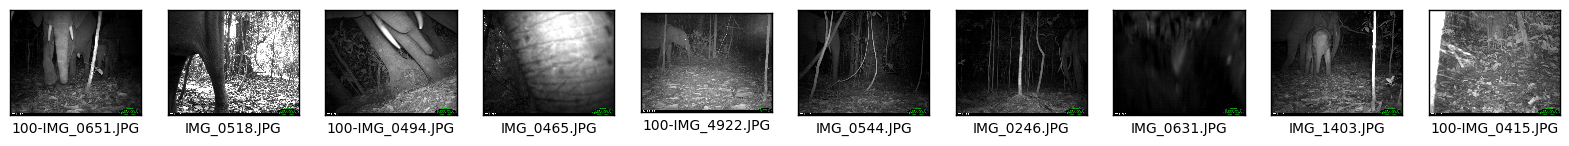

In [7]:
# use matplotlib to view randomly selected sample images
rand_images = np.random.choice(files, 10)

# plot images
fig, axes = plt.subplots(1,len(rand_images),figsize=(len(rand_images)*2, 8),subplot_kw={'xticks': (), 'yticks': ()})
for i, axis in enumerate(axes.flat):
    axis.imshow(read_image(rand_images[i],False))
    axis.set(xticks=[], yticks=[],xlabel=os.path.basename(rand_images[i]))

# Image Segmentation

## Manual Crop

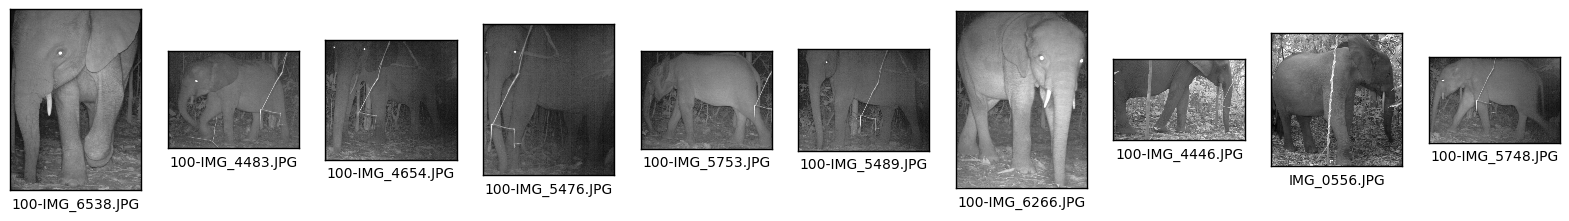

In [9]:
# view a sample of cropped images

# define cropped images directory
DIRECTORY = ''

# return all manually-cropped images
loxodonta_files = get_files(DIRECTORY,'Loxodonta',".JPG")

# use matplotlib to view randomly selected sample images
rand_images = np.random.choice(loxodonta_files, 10)

# plot images
fig, axes = plt.subplots(1,len(rand_images),figsize=(len(rand_images)*2, 8),subplot_kw={'xticks': (), 'yticks': ()})
for i, axis in enumerate(axes.flat):
    axis.imshow(read_image(rand_images[i],False))
    axis.set(xticks=[], yticks=[],xlabel=os.path.basename(rand_images[i]))

Image shape is: (1291, 788, 3) of type uint8
Grayscale image shape is: (1291, 788) of type uint8


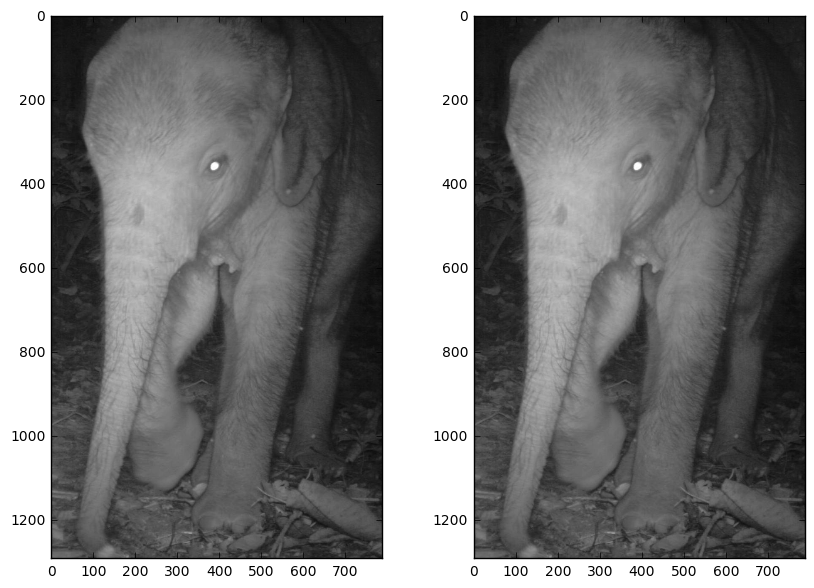

Image shape is: (1024, 1280, 3) of type uint8
Grayscale image shape is: (1024, 1280) of type uint8


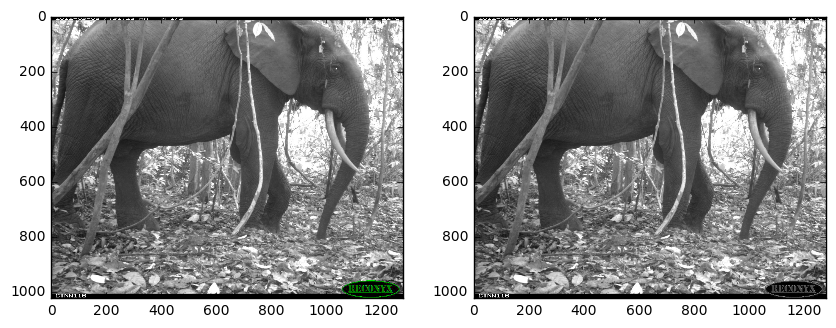

In [15]:
# read random cropped images into array to show data types and shapes and plot

rand1 = np.random.choice(loxodonta_files, 1)[0] # returns file name for randomly selected image
rand2 = np.random.choice(loxodonta_files, 1)[0] # retruns file name for randomly selected image

# use OpenCV to read image to array
img_rand1 = read_image(rand1)
print("Image shape is: {0} of type {1}".format(img_rand1.shape, img_rand1.dtype))

# use Open CV to read grayscale version to float array
img_rand1_gray = to_gray(img_rand1)
print("Grayscale image shape is: {0} of type {1}".format(img_rand1_gray.shape, img_rand1_gray.dtype))

# view randomly selected images
plt.subplots(figsize=(10, 7))
plt.subplot(121), plt.imshow(img_rand1, cmap='gray');
plt.subplot(122),plt.imshow(img_rand1_gray, cmap='gray');
plt.show()

# use OpenCV to read another image to array
img_rand2 = read_image(rand2)
print("Image shape is: {0} of type {1}".format(img_rand2.shape, img_rand2.dtype))

# use Open CV to read another grayscale version to float array
img_rand2_gray = to_gray(img_rand2)
print("Grayscale image shape is: {0} of type {1}".format(img_rand2_gray.shape, img_rand2_gray.dtype))

# view other randomly selected images
plt.subplots(figsize=(10, 7))
plt.subplot(121), plt.imshow(img_rand2, cmap='gray');
plt.subplot(122),plt.imshow(img_rand2_gray, cmap='gray');
plt.show()

## Graph Cut

In [ ]:
# https://raw.githubusercontent.com/opencv/opencv/master/samples/python/grabcut.py

# Feature Extraction

## Histogram Equalization

In [ ]:
# #http://docs.opencv.org/trunk/d5/daf/tutorial_py_histogram_equalization.html

# hist,bins = np.histogram(base.flatten(),256,[0,256])
# cdf = hist.cumsum()
# cdf_normalized = cdf * hist.max()/ cdf.max()

# plt.plot(cdf_normalized, color = 'b')
# plt.hist(base.flatten(),256,[0,256], color = 'r')
# plt.xlim([0,256])
# plt.legend(('cdf','histogram'), loc = 'upper left')
# plt.show()

## Template Matching

In [ ]:
# img2 = img_rand1_gray
# w, h = template.shape[::-1]

# # All the 6 methods for comparison in a list
# methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
#             'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

# for meth in methods:
#     img_rand1 = img2
#     method = eval(meth)
 
#     # Apply template Matching
#     res = cv2.matchTemplate(img_rand1,template,method)
#     min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

#     # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
#     if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
#         top_left = min_loc
#     else:
#         top_left = max_loc
#     bottom_right = (top_left[0] + w, top_left[1] + h)

#     cv2.rectangle(img_rand1_gray,top_left, bottom_right, 255, 2)
#     fig, ax = plt.subplots(figsize=(12, 7))
#     plt.subplot(121),plt.imshow(res,cmap = 'gray')
#     plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
#     plt.subplot(122),plt.imshow(img_rand1_gray,cmap = 'gray') #,aspect='auto'
#     plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
#     plt.suptitle(meth)

#     plt.show()

# Scale Invariant Feature Transform

SIFT interest point locations are found using difference-of-Gaussian functions

*D(x, σ) = [Gkσ (x) − Gσ (x)] ∗ I (x) = [Gkσ − Gσ ] ∗ I = Ikσ − Iσ *,

where *Gσ* is the Gaussian 2D kernel, *Iσ* the *Gσ* -blurred grayscale image, and *k*  is a constant factor determining the separation in scale. Interest points are the maxima and minima of *D(x, σ)* across both image location and scale. These candidate locations are filtered to remove unstable points. Points are dismissed based on a number of criteria, like low contrast and points on edges.

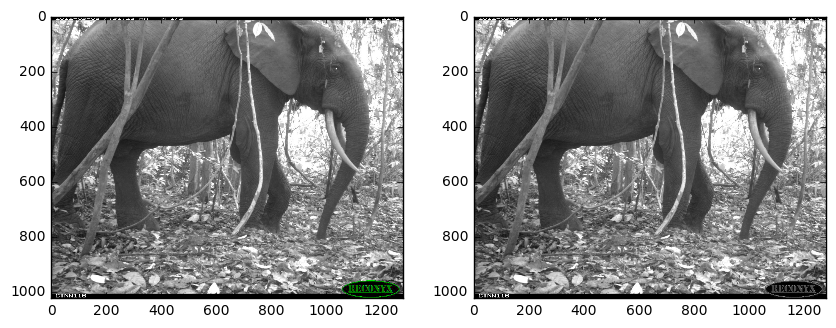

In [16]:
# view randomly selected images for SIFT implementation
plt.subplots(figsize=(10, 7))
plt.subplot(121), plt.imshow(img_rand2, cmap='gray');
plt.subplot(122),plt.imshow(img_rand2_gray, cmap='gray');
plt.show()

Here are what our SIFT features look like for the loxodonta image:


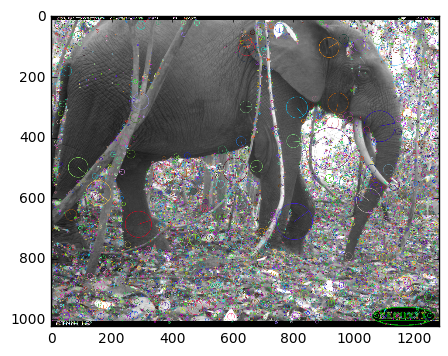

In [49]:
# OpenCV implementation
# Create a SIFT Object
SIFT_img = img_rand2
keypoints, descriptors = gen_fd_features(SIFT_img,True)

# Now we draw the gray image and overlay the Key Points (kp)
# Plot it to the screen
print('Here are what our SIFT features look like for the loxodonta image:')
show_sift_features(SIFT_img,keypoints)

Here are what our SIFT features look like for the loxodonta image using detect:


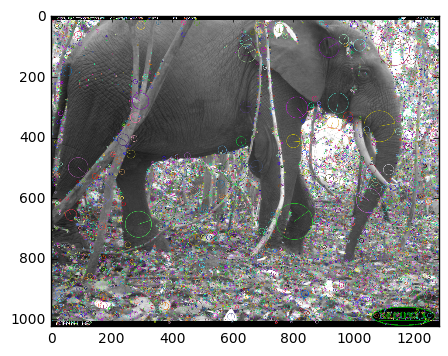

In [50]:
# Create a SIFT Object
SIFT_img = img_rand2
keypoints, _ = gen_fd_features(SIFT_img,False)

# Now we draw the gray image and overlay the Key Points (kp)
# Plot it to the screen
print('Here are what our SIFT features look like for the loxodonta image using detect:')
show_sift_features(SIFT_img,keypoints)

In [ ]:
# create a BFMatcher object which will match up the SIFT features
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(img_rand1_desc,img_rand12_desc)

# Sort the matches in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# draw the top N matches
N_MATCHES = 100

match_img = cv2.drawMatches(
    img_rand1, img_rand1_kp,
    img_rand12, img_rand12_kp,
    matches[:N_MATCHES], img_rand12.copy(), flags=0)

plt.figure(figsize=(12,6))
plt.imshow(match_img);

In [ ]:
img_rand1_desc

In [ ]:
print(len(img_rand1_kp), 'keypoints in the list')
print(img_rand1_kp[0])

In [ ]:
def explain_keypoint(kp):
    print('angle\n', kp.angle)
    print('\nclass_id\n', kp.class_id)
    print('\noctave (image scale where feature is strongest)\n', kp.octave)
    print('\npt (x,y)\n', kp.pt)
    print('\nresponse\n', kp.response)
    print('\nsize\n', kp.size)

print('this is an example of a single SIFT keypoint:\n* * *')
explain_keypoint(img_rand1_kp[0])

In [ ]:
print('SIFT descriptors are vectors of shape', img_rand1_desc[0].shape)
print('they look like this:')
img_rand1_desc[0]

In [ ]:
# visualized another way:
plt.imshow(img_rand1_desc[0].reshape(16,8), interpolation='none');

## Bag of Words Visual Model

In [ ]:
SCORING = 'accuracy'
print('Scoring grid search with metric: %s' % SCORING)

In [ ]:
# adapted from Ian London
# tools to run a Visual Bag of Words classifier on any images

def read_image(path):
    img = cv2.imread(path)
    if img is None:
        raise IOError("Unable to open '%s'.")
    return img


def neg_img_cal101(positive_folder, cal101_root='101_ObjectCategories', image_suffix='*.jpg'):
    """Simply return list of paths for all images in cal101 dataset, except those in positive_folder."""
    return [path for path in glob.glob(cal101_root + '/*/' + image_suffix) if positive_folder not in path]


def binary_labeled_img_from_cal101(positive_folder, cal101_root='101_ObjectCategories', image_suffix='*.jpg'):
    """
    Generate a balanced dataset of positive and negative images from a directory of images
    where each type of image is separated in its own folder.

    Returns:
    --------
    labeled_img_paths: list of lists
        Of the form [[image_path, label], ...]
        Where label is True or False for positive and negative images respectively
    """
    all_imgs = set(glob.glob(cal101_root + '/*/' + image_suffix))
    pos_imgs = set(glob.glob(os.path.join(cal101_root, positive_folder) + '/' + image_suffix))
    neg_imgs = all_imgs - pos_imgs

    neg_sample_size = len(pos_imgs)
    selected_negs = np.random.choice(list(neg_imgs), size=neg_sample_size, replace=False)

    print('%i positive, %i negative images selected (out of %i negatives total)') % (
        len(pos_imgs), len(selected_negs), len(neg_imgs))

    labeled_img_paths = [[path, True] for path in pos_imgs] + [[path, False] for path in selected_negs]

    return np.array(labeled_img_paths)


def train_test_val_split_idxs(total_rows, percent_test, percent_val):
    """
    Get indexes for training, test, and validation rows, given a total number of rows.
    Assumes indexes are sequential integers starting at 0: eg [0,1,2,3,...N]

    Returns:
    --------
    training_idxs, test_idxs, val_idxs
        Both lists of integers
    """
    if percent_test + percent_val >= 1.0:
        raise ValueError('percent_test and percent_val must sum to less than 1.0')

    row_range = range(total_rows)

    no_test_rows = int(total_rows*(percent_test))
    test_idxs = np.random.choice(row_range, size=no_test_rows, replace=False)
    # remove test indexes
    row_range = [idx for idx in row_range if idx not in test_idxs]

    no_val_rows = int(total_rows*(percent_val))
    val_idxs = np.random.choice(row_range, size=no_val_rows, replace=False)
    # remove validation indexes
    training_idxs = [idx for idx in row_range if idx not in val_idxs]

    print('Train-test-val split: %i training rows, %i test rows, %i validation rows' % (len(training_idxs), len(test_idxs), len(val_idxs)))

    return training_idxs, test_idxs, val_idxs


def gen_fd_features(labeled_img_paths):
    """
    Generate SIFT features for images

    Parameters:
    -----------
    labeled_img_paths : list of lists
        Of the form [[image_path, label], ...]

    Returns:
    --------
    img_descs : list of SIFT descriptors with same indicies as labeled_img_paths
    y : list of corresponding labels
    """
    # img_keypoints = {}
    img_descs = []

    print('generating SIFT descriptors for %i images' % len(labeled_img_paths))

    for img_path, label in labeled_img_paths:
        img = read_image(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        kp, desc = sift.detectAndCompute(gray, None)
        # img_keypoints[img_path] = kp
        img_descs.append(desc)

    print('SIFT descriptors generated.')

    y = np.array(labeled_img_paths)[:,1]

    return img_descs, y


def cluster_features(img_descs, training_idxs, cluster_model):
    """
    Cluster the training features using the cluster_model
    and convert each set of descriptors in img_descs
    to a Visual Bag of Words histogram.

    Parameters:
    -----------
    X : list of lists of SIFT descriptors (img_descs)

    training_idxs : array/list of integers
        Indicies for the training rows in img_descs

    cluster_model : clustering model (eg KMeans from scikit-learn)
        The model used to cluster the SIFT features

    Returns:
    --------
    X, cluster_model :
        X has K feature columns, each column corresponding to a visual word
        cluster_model has been fit to the training set
    """
    n_clusters = cluster_model.n_clusters

    # # Generate the SIFT descriptor features
    # img_descs = gen_fd_features(labeled_img_paths)
    #
    # # Generate indexes of training rows
    # total_rows = len(img_descs)
    # training_idxs, test_idxs, val_idxs = train_test_val_split_idxs(total_rows, percent_test, percent_val)

    # Concatenate all descriptors in the training set together
    training_descs = [img_descs[i] for i in training_idxs]
    all_train_descriptors = [desc for desc_list in training_descs for desc in desc_list]
    all_train_descriptors = np.array(all_train_descriptors)

    if all_train_descriptors.shape[1] != 128:
        raise ValueError('Expected SIFT descriptors to have 128 features, got', all_train_descriptors.shape[1])

    print('%i descriptors before clustering' % all_train_descriptors.shape[0])

    # Cluster descriptors to get codebook
    print('Using clustering model %s...' % repr(cluster_model))
    print('Clustering on training set to get codebook of %i words' % n_clusters)

    # train kmeans or other cluster model on those descriptors selected above
    cluster_model.fit(all_train_descriptors)
    print('done clustering. Using clustering model to generate BoW histograms for each image.')

    # compute set of cluster-reduced words for each image
    img_clustered_words = [cluster_model.predict(raw_words) for raw_words in img_descs]

    # finally make a histogram of clustered word counts for each image. These are the final features.
    img_bow_hist = np.array(
        [np.bincount(clustered_words, minlength=n_clusters) for clustered_words in img_clustered_words])

    X = img_bow_hist
    print('done generating BoW histograms.')

    return X, cluster_model

def perform_data_split(X, y, training_idxs, test_idxs, val_idxs):
    """
    Split X and y into train/test/val sets

    Parameters:
    -----------
    X : eg, use img_bow_hist
    y : corresponding labels for X
    training_idxs : list/array of integers used as indicies for training rows
    test_idxs : same
    val_idxs : same

    Returns:
    --------
    X_train, X_test, X_val, y_train, y_test, y_val
    """
    X_train = X[training_idxs]
    X_test = X[test_idxs]
    X_val = X[val_idxs]

    y_train = y[training_idxs]
    y_test = y[test_idxs]
    y_val = y[val_idxs]

    return X_train, X_test, X_val, y_train, y_test, y_val


def img_to_vect(img_path, cluster_model):
    """
    Given an image path and a trained clustering model (eg KMeans),
    generates a feature vector representing that image.
    Useful for processing new images for a classifier prediction.
    """

    img = read_image(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, desc = sift.detectAndCompute(gray, None)

    clustered_desc = cluster_model.predict(desc)
    img_bow_hist = np.bincount(clustered_desc, minlength=cluster_model.n_clusters)

    # reshape to an array containing 1 array: array[[1,2,3]]
    # to make sklearn happy (it doesn't like 1d arrays as data!)
    return img_bow_hist.reshape(1,-1)

In [ ]:
# Get all possible negative images and label them False
positive_folder='elephant'
all_negs = [(path, False) for path in neg_img_cal101(positive_folder)]
print('%i total negative imgs to choose from' % len(all_negs))
print(all_negs[:5])

In [ ]:
# Get all the positive images in loxodonta folder and label them True
positive_imgs = [(path, True) for path in glob.glob('Loxodonta/*')]
print('%i positive images' % len(positive_imgs))
print(positive_imgs[:5])

In [ ]:
# take N random negative images, where N is no of positive images
# then concatenate N pos + N neg and shuffle.
chosen_negs = random.sample(all_negs, len(positive_imgs))
imgs = chosen_negs + positive_imgs

np.random.shuffle(imgs)

print('%i total images (1:1 positive:negative)' % len(imgs))
print(imgs[:5])

In [ ]:
%%time

img_descs, y = gen_fd_features(imgs)

In [ ]:
joblib.dump(img_descs, 'pickles/img_descs/img_descs.pickle')
joblib.dump(y, 'pickles/img_descs/y.pickle')

In [ ]:
# generate indexes for train/test/val split
training_idxs, test_idxs, val_idxs = train_test_val_split_idxs(
    total_rows=len(imgs), 
    percent_test=0.15, 
    percent_val=0.15
)

# Cluster the SIFT descriptors

In [ ]:
%%time

K_CLUSTERS = 10

# Method to ignore MiniBatchKMeans errors and warnings
warnings.filterwarnings('ignore')

X, cluster_model = cluster_features(
    img_descs, 
    training_idxs=training_idxs, 
    cluster_model=MiniBatchKMeans(n_clusters=K_CLUSTERS)
)

warnings.filterwarnings('default')

X_train, X_test, X_val, y_train, y_test, y_val = perform_data_split(X, y, training_idxs, test_idxs, val_idxs)

In [ ]:
for obj, obj_name in zip( [X_train, X_test, X_val, y_train, y_test, y_val], 
                         ['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val'] ):
    joblib.dump(obj, 'pickles/feature_data/%s.pickle' % obj_name)

In [ ]:
for obj_name in ['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val']:
    exec("{obj_name} = joblib.load('pickles/feature_data/{obj_name}.pickle')".format(obj_name=obj_name))
    exec("print(obj_name, len({0}))".format(obj_name))

# Classification

## Linear SVM

In [ ]:
%%time

# c_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# c_vals = [0.01, 1, 10]
c_vals = [0.1,1,10]

# gamma_vals = [0.5, 0.1, 0.01, 0.0001, 0.00001]
# gamma_vals = [0.1, 0.00001]
gamma_vals = [0.1,1]

param_grid = [
    {'C': c_vals, 'gamma': gamma_vals, 'kernel': ['linear']}
 ]

svc = GridSearchCV(SVC(), param_grid, n_jobs=-1, scoring=SCORING)
svc.fit(X_train, y_train)
print('train score (%s):'%SCORING, svc.score(X_train, y_train))
print('test score (%s):'%SCORING, svc.score(X_test, y_test))

print(svc.best_estimator_)

In [ ]:
print("Best parameters: {}".format(svc.best_params_))
print("Best cross-validation score: {:.2f}".format(svc.best_score_))

In [ ]:
print()
# convert to DataFrame
results = pd.DataFrame(svc.grid_scores_)
# show the first 5 rows
results.head()

In [ ]:
for img_path, label in random.sample(all_negs, 25):
    print(img_path, svc.predict(img_to_vect(img_path, cluster_model)))

In [ ]:
joblib.dump(svc.best_estimator_, 'pickles/svc/svc.pickle')
joblib.dump(cluster_model, 'pickles/cluster_model/cluster_model.pickle')

# Exploratory: Using AdaBoost

In [ ]:
%%time

ada_params = {
    'n_estimators':[100, 250, 500, 750],
    'learning_rate':[0.8, 0.9, 1.0, 1.1, 1.2]
}

# ada = AdaBoostClassifier(n_estimators=MAX_ESTIMATORS, learning_rate=0.8)
ada = GridSearchCV(AdaBoostClassifier(), ada_params, n_jobs=-1, scoring=SCORING)
ada.fit(X_train, y_train)
print('train score (%s):'%SCORING, ada.score(X_train, y_train))
print('test score (%s):'%SCORING, ada.score(X_test, y_test))
print(ada.best_estimator_)

In [ ]:
print("Best parameters: {}".format(ada.best_params_))
print("Best cross-validation score: {:.2f}".format(ada.best_score_))

In [ ]:
joblib.dump(ada.best_estimator_, 'pickles/ada_boost/ada.pickle');
print('pickled adaboost')

In [ ]:
X_all = np.ndarray((len(files), ROWS, COLS, CHANNELS), dtype=np.uint8)
for i, im in enumerate(files): 
    X_all[i] = read_image(DIRECTORY+species+'/'+im)
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

print(X_all.shape)

In [ ]:
# check out a species from each class
uniq = np.unique(y_all, return_index=True)
for f, i in zip(uniq[0], uniq[1]):
    plt.imshow(X_all[i])
    plt.title(f)
    plt.show()

In [ ]:
def cluster_and_split(img_descs, y, training_idxs, test_idxs, val_idxs, K):
    """Cluster into K clusters, then split into train/test/val"""
    # MiniBatchKMeans annoyingly throws tons of deprecation warnings that fill up the notebook. Ignore them.
    warnings.filterwarnings('ignore')

    X, cluster_model = cluster_features(
        img_descs,
        training_idxs=training_idxs,
        cluster_model=MiniBatchKMeans(n_clusters=K)
    )

    warnings.filterwarnings('default')

    X_train, X_test, X_val, y_train, y_test, y_val = perform_data_split(X, y, training_idxs, test_idxs, val_idxs)

    return X_train, X_test, X_val, y_train, y_test, y_val, cluster_model

def run_svm(X_train, X_test, y_train, y_test, scoring,
    c_vals=[1, 5, 10], gamma_vals=[0.1, 0.01, 0.0001, 0.00001]):

    param_grid = [
    #   {'C': c_vals, 'kernel': ['linear']},
      {'C': c_vals, 'gamma': gamma_vals, 'kernel': ['rbf']},
     ]

    svc = GridSearchCV(SVC(), param_grid, n_jobs=-1, scoring=scoring)
    svc.fit(X_train, y_train)
    print('train score (%s):'%scoring, svc.score(X_train, y_train))
    test_score = svc.score(X_test, y_test)
    print('test score (%s):'%scoring, test_score)

    print(svc.best_estimator_)

    return svc, test_score

def run_ada(X_train, X_test, y_train, y_test, scoring,
    n_estimators=[50, 100, 250], learning_rate=[1.0, 1.5]):

    ada_params={
        'n_estimators':n_estimators,
        'learning_rate':learning_rate
    }

    ada = GridSearchCV(AdaBoostClassifier(), ada_params, n_jobs=-1, scoring=scoring)
    ada.fit(X_train, y_train)

    print('train score (%s):'%scoring, ada.score(X_train, y_train))
    test_score = ada.score(X_test, y_test)
    print('test score (%s):'%scoring, test_score)
    print(ada.best_estimator_)

    return ada, test_score

In [ ]:
# Grid search over K, SVM params, and AdaBoost params.
# Use SIFT features generated
# adapted from Ian London

scoring = 'accuracy'

# load SIFT features
img_descs = joblib.load('pickles/img_descs/img_descs.pickle')
y = joblib.load('pickles/img_descs/y.pickle')

print(len(img_descs), len(y))


# generate indexes for train/test/val split
training_idxs, test_idxs, val_idxs = train_test_val_split_idxs(
    total_rows=len(img_descs),
    percent_test=0.15,
    percent_val=0.15
)

results = {}
K_vals = [10, 20, 40, 80]

for K in K_vals:
    X_train, X_test, X_val, y_train, y_test, y_val, cluster_model = cluster_and_split(
        img_descs, y, training_idxs, test_idxs, val_idxs, K)

    print("\nInertia for clustering with K=%i is:" % K, cluster_model.inertia_)

    print('\nSVM Scores: ')
    svmGS, svm_score = run_svm(X_train, X_test, y_train, y_test, scoring)
    print('\nAdaBoost Scores: ')
    adaGS, ada_score = run_ada(X_train, X_test, y_train, y_test, scoring)

    results[K] = dict(
        inertia = cluster_model.inertia_,
        svmGS=svmGS,
        adaGS=adaGS,
        cluster_model=cluster_model,
        svm_score=svm_score,
        ada_score=ada_score)

    print('\n*** K=%i DONE ***\n' % K)

print('**************************')
print('***** FINISHED ALL K *****')
print('**************************\n')

# pickle for later analysis
###########################

feature_data_path = 'pickles/k_grid_feature_data/'
result_path = 'pickles/k_grid_result'

# delete previous pickles
for path in [feature_data_path, result_path]:
    for f in glob.glob(path+'/*'):
        os.remove(f)

print('pickling X_train, X_test, X_val, y_train, y_test, y_val')

for obj, obj_name in zip( [X_train, X_test, X_val, y_train, y_test, y_val],
                         ['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val'] ):
    joblib.dump(obj, '%s%s.pickle' % (feature_data_path, obj_name))

print('pickling results')

exports = joblib.dump(results, '%s/result.pickle' % result_path)

print('\n* * *')
print('Scored grid search with metric: "%s"' % scoring)

K_vals = sorted(results.keys())
for K in K_vals:
    print('For K = %i:\tSVM %f\tAdaBoost %f\tK-Means Inertia %f' % (
        K, results[K]['svm_score'], results[K]['ada_score'], results[K]['inertia']));

In [ ]:
# Load from pickles generated in previous step
results = joblib.load('pickles/k_grid_result/result.pickle')

for obj_name in ['X_train', 'X_test', 'X_val', 'y_train', 'y_test', 'y_val']:
    exec("{obj_name} = joblib.load('pickles/k_grid_feature_data/{obj_name}.pickle')".format(obj_name=obj_name))

print('train:', len(X_train))
print('test:', len(X_test))
print('val:', len(X_val))
    

K_vals = sorted(results.keys())
for K in K_vals:
    print('For K = %i:\tSVM %f\tAdaBoost %f\tK-Means Inertia %f' % (
        K, results[K]['svm_score'], results[K]['ada_score'], results[K]['inertia']));


In [ ]:
svc = results[80]['svmGS']
print(svc.best_estimator_)

In [ ]:
y_score = svc.decision_function(X_test) #dist of samples to the boundary hyperplane
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label='True')
roc_auc = metrics.auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
target_labels = ['True','False']
target_names = ['loxodonta','not loxodonta']

y_pred = svc.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=target_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i, cas in enumerate(cm):
        for j, c in enumerate(cas):
            # formatting for ints vs floats
            if isinstance(c, int):
                plt.text(j-.2, i+.2, c, fontsize=14)
            else:
                plt.text(j-.2, i+.2, '%.2f' % c, fontsize=14)

plot_confusion_matrix(cm)

In [ ]:
# rows add up to 1.0
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix (rows add to 1.0)')

In [ ]:
print(metrics.classification_report(y_test, y_pred, labels=target_labels, target_names=target_names))

In [ ]:
# CSS styling within IPython notebook
from IPython.display import display, HTML
display(HTML(open('css/custom.css').read()))